# Exploration of high-dimensional analysis of primary cultures spike train data

This notebook uses my own (Geert Timmerman) method of obtaining the firing rate

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

#### Overview of the data

In [2]:
data = np.load('sorted_baseline.npz', allow_pickle=True)

keys = list(data.keys())

for key in keys:
    content = data[key]
    print(key.ljust(10),
          str(np.shape(content)).ljust(10),
          str(type(content)))
    
units = data['units']
locations = data['locations']
samplerate = int(data['fs'])

units      (302,)     <class 'numpy.ndarray'>
locations  (972, 2)   <class 'numpy.ndarray'>
fs         ()         <class 'numpy.ndarray'>


In [3]:
units_keys = units[0].keys()

print('Units consists of an array of dictionary with more data', end='\n\n')

for key in units_keys:
    content = units[1][key]
    print(key.ljust(12),
          str(np.shape(content)).ljust(12),
          str(type(content)))

Units consists of an array of dictionary with more data

unit_id      ()           <class 'int'>
spike_train  (353,)       <class 'numpy.ndarray'>
x_max        ()           <class 'numpy.float64'>
y_max        ()           <class 'numpy.float64'>
template     (141, 972)   <class 'numpy.memmap'>
electrode    ()           <class 'numpy.int32'>


### Pre-processing the data

Order the data from most to least active unit and obtain the last frame (`total_size`) at which a firing happened, i.e. the total number of frames. 

In [4]:
activity = np.array([])
total_size = 0

for unit in units:
    activity = np.append(activity, len(unit['spike_train']))

    try:
        if unit['spike_train'][-1] > total_size:
            total_size = unit['spike_train'][-1]
    except:
        continue
 

unit_number = np.arange(0, len(units))
units = units[np.argsort(-1*activity)]

Create a binary array of size `(#units, total_size)` with a value `1` if the unit has fired, and `0` if it did not fire. 

In [5]:
binary_firings = np.full( (len(units), total_size+1), False, dtype=np.bool_)

for i, unit in enumerate(units):
    binary_firings[i][unit['spike_train']] = True

From this binary array we can obtain the firing rate per frame by summing over all units each time step. Because of the high frame rate this gives a very noisy output. We therefore take a running average. To reduce the amount of data and computation time we take an average every `step` frames. 

In [ ]:
firing_rate = np.sum(binary_firings, axis=0) #get firing rate per frame

window_size = 0.03 # seconds
window = samplerate * window_size # window in number of frames
step = window / 20

time = np.arange(0, len(firing_rate)/samplerate, 1/samplerate)

firing_rate_avg = []
time_avg = []

for i in range(0, len(firing_rate), int(step)):

    firing_rate_avg.append(np.sum(firing_rate[i:i+int(window)])/window_size)
    
    time_avg.append(time[i]+window_size)

firing_rate_avg = np.array(firing_rate_avg)
time_avg = np.array(time_avg)


Now we can plot the data

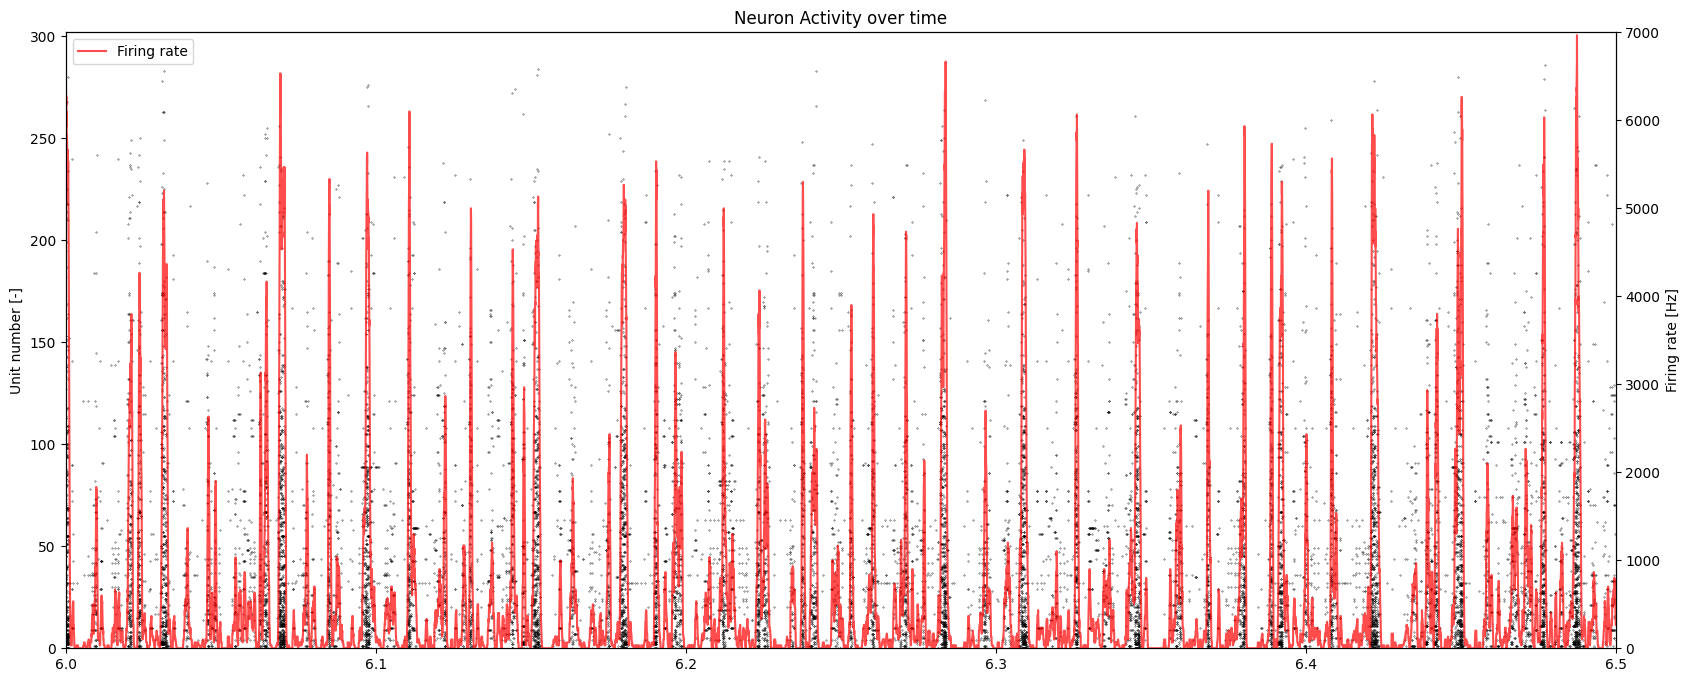

Total measurement time: 15 min 0.043 s


In [7]:
fig, ax1 = plt.subplots(figsize=(20, 8))

plt.title('Neuron Activity over time')

for i, unit in enumerate(units):
    ax1.scatter(unit['spike_train']/samplerate/60, 
                np.full_like(unit['spike_train'], unit_number[i]), 
                s=.07, color='k')

ax1.set_ylabel('Unit number [-]')
ax1.set_ylim(0, len(units))

ax2 = ax1.twinx() 
ax2.plot(time_avg/60, firing_rate_avg, c='r', alpha=.7, label='Firing rate')
ax2.set_ylim(0, 7000)
ax2.set_ylabel('Firing rate [Hz]')
ax2.legend()

plt.xlabel('Time [min]')
plt.xlim(6, 6.5)
plt.show()

print(f'Total measurement time: {int(time[-1]//60)} min {round(time[-1]%60, 3)} s')

### Dimensional reduction on binary data: PCA

We perform Principal Component Analysis (PCA) on the binary data. To do this we interpret each time frame as point in $\mathbb{R}^{N_{units}}_+$, where each degree of freedom corresponds with either activation (1) or no activation (0). Note that the binary data is a $N_{units}$-dimensional hypercube with $2^{N_{units}}$ vertices, with a high degree of degeneracy at the vertices.

First we reduce the dimensionality to 2D: 

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
PCA_binary_2d = pca.fit_transform(binary_firings.T)

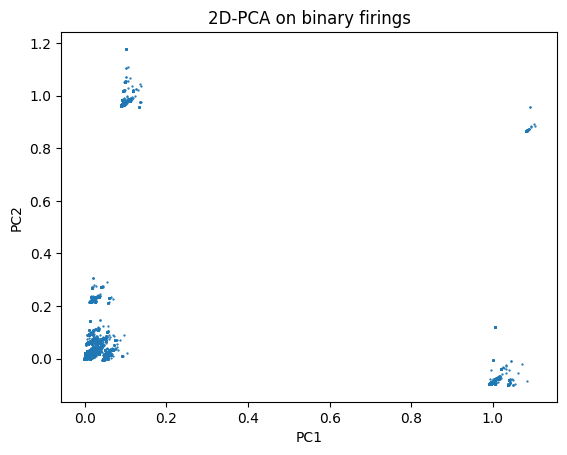

In [9]:
plt.figure()
plt.title('2D-PCA on binary firings')
plt.scatter(PCA_binary_2d[:,0], PCA_binary_2d[:,1], s=.4)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

3D:

In [10]:
pca = PCA(n_components=3)
PCA_binary_3d = pca.fit_transform(binary_firings.T)

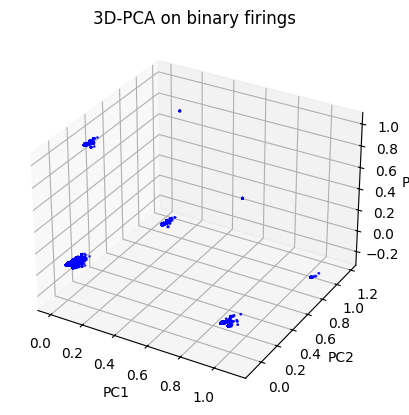

In [11]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-PCA on binary firings')
# Create a 3D scatter plot
ax.scatter(PCA_binary_3d[:,0], PCA_binary_3d[:,1], PCA_binary_3d[:,2], s=1, c='b', marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

One of the problems with this method is in a large part of the frames, no neurons are fired, leading to a bias towards the origin of the hypercube. 

In [12]:
print(f'Fraction of frames with no neurons firing: {round(np.sum(firing_rate==0)/len(firing_rate)*100, 2)} %')

Fraction of frames with no neurons firing: 97.18 %


Lets have a look at the same methods applied, but now disregarding the non-firing frames. 

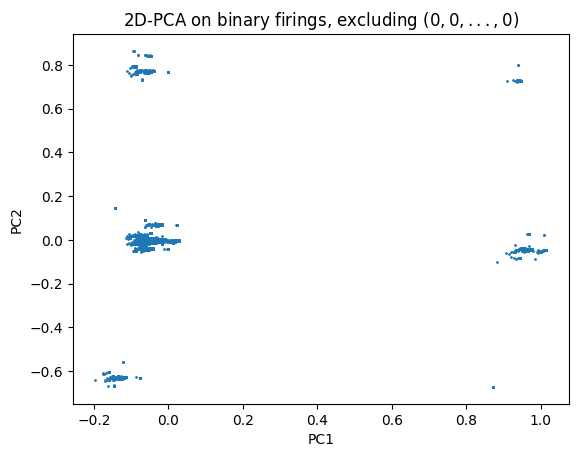

In [13]:
binary_firings_sliced = binary_firings[:,firing_rate!=0]

pca = PCA(n_components=2)
PCA_binary_sliced_2d = pca.fit_transform(binary_firings_sliced.T)

plt.figure()
plt.title(r'2D-PCA on binary firings, excluding $(0, 0, ..., 0)$')
plt.scatter(PCA_binary_sliced_2d[:,0], PCA_binary_sliced_2d[:,1], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

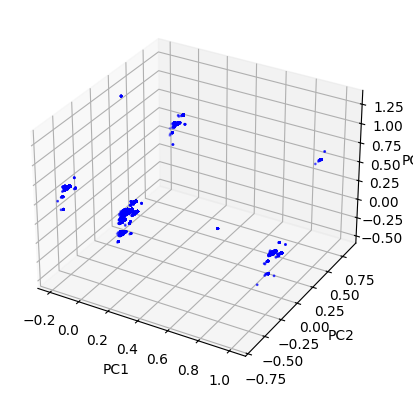

In [14]:
pca = PCA(n_components=3)
PCA_binary_sliced_3d = pca.fit_transform(binary_firings_sliced.T)

fig = plt.figure()
ax.set_title(r'2D-PCA on binary firings, excluding $(0, 0, ..., 0)$')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_binary_sliced_3d[:,0], PCA_binary_sliced_3d[:,1], PCA_binary_sliced_3d[:,2], s=1, c='b', marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

### Dimensional reduction on smoothed data: PCA, UMAP and t-SNE

A different way of dealing with the data is to smooth it with a Gaussian kernel. We first apply the convolution to a few examples to tune the standard deviation of the kernel. Because the binary data is a large amount of data, we use a convolution with stride to reduce the number of data points. Especially when applying this to all data and using that data for dimensional reduction schemes like t-SNE and UMAP, when need less data points to reduce the computational complexity. It is always important to be aware that you have enough data points to keep the curves smooth. 

$$f_{sample} = 20\text{ kHz} \rightarrow t_{sample} = 50 \ \mu\text{s}$$
$$\sigma = 10000 \ \mu\text{s}$$

A stride of $N_{stride}$ data points means $t_{stride} = N_{stride}/f_{sample}$, so we need:

$$\sigma \gg t_{stride} > t_{sample}$$

If we want atleast 20 data points per kernel, we can get a stride of

$$N_{stride} = \frac{\sigma}{2*t_{sample}} = 10$$

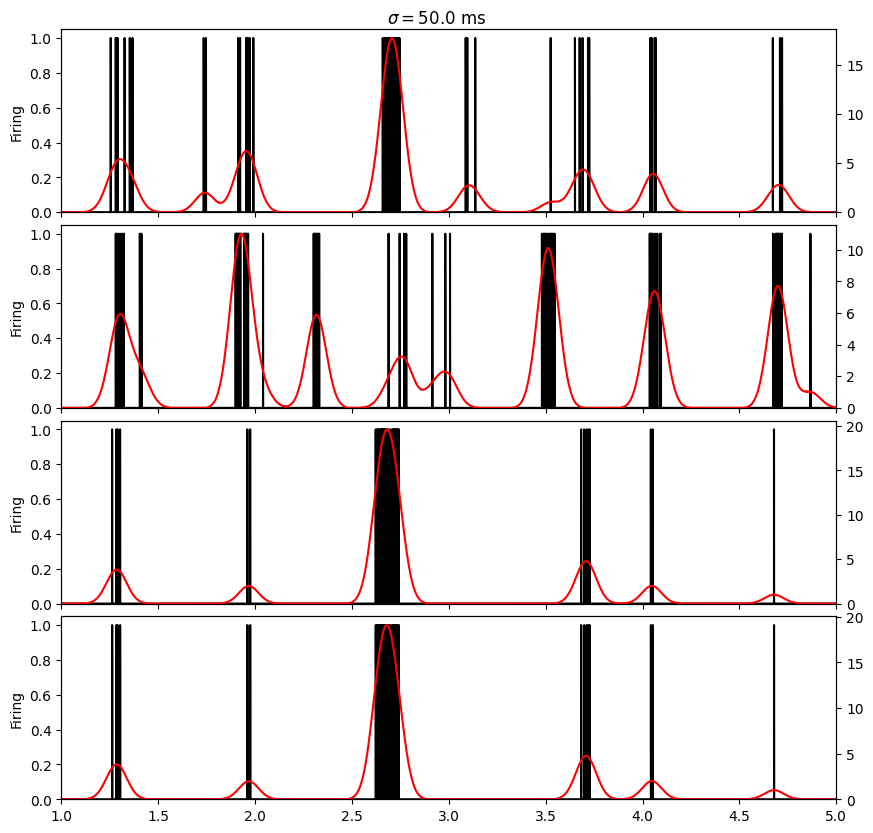

In [15]:
def gaussian_kernel(size, sigma):
    x = np.linspace(-size // 2, size // 2, int(size))
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel

def convolution(input, kernel, stride=1, padding='same'):
    input_length = len(input)
    kernel_length = len(kernel)
    output_length = (input_length - kernel_length) // stride + 1

    if padding == 'same':
        pad_size = (kernel_length - 1) // 2
        input = np.pad(input, (pad_size, pad_size), mode='constant')
    elif padding == 'valid':
        pad_size = 0
    else:
        raise ValueError("Padding must be either 'same' or 'valid'")
    
    padded_input_length = len(input)

    output_length = (padded_input_length - kernel_length) // stride + 1

    output = np.zeros(output_length)

    for i in range(0, output_length):
        start_index = i * stride
        output[i] = np.dot(input[start_index:start_index + kernel_length], kernel)

    return output


kernel_size = .3 # seconds
sigma = .05 # seconds
stride = 2 # seconds * samplerate
gaussian = gaussian_kernel(kernel_size*samplerate, sigma*samplerate)

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
plt.subplots_adjust(hspace=.07)
plt.suptitle(r'$\sigma =$'+str(sigma*1e3)+' ms', y=.9)

time_xlim = (1, 5)

for unit, ax in zip(binary_firings[0:len(axs)], axs):

    # only convolve and plot part to save time
    index_min = np.argmin(np.abs(time - time_xlim[0]))
    index_max = np.argmin(np.abs(time - time_xlim[1]))

    convolved = convolution(unit[index_min:index_max], gaussian, stride=stride)

    ax.plot(time[index_min:index_max], unit[index_min:index_max], c='k')
    axright = ax.twinx()
    axright.plot(time[index_min:index_max:stride], convolved, c='r')
    ax.set_ylabel('Firing')
    ax.set_ylim(0)
    axright.set_ylim(0)

plt.xlabel('Time [s]')
plt.xlim(time_xlim)
plt.show()



Now apply this smoothing to all data

In [16]:
for i, unit in tqdm(enumerate(binary_firings)):
    conv_result = convolution(unit, gaussian, stride=20)
    if i==0:
        firings_smooth = conv_result
    else:
        firings_smooth = np.vstack((firings_smooth, conv_result))


time_smooth = time[::stride]

302it [26:21,  5.24s/it]


Save the data for later use

In [17]:
np.savetxt('firings_smooth_10ms.csv', firings_smooth, delimiter=',')

In [18]:
firings_smooth = np.loadtxt('firings_smooth_10ms.csv', delimiter=',')

#### PCA

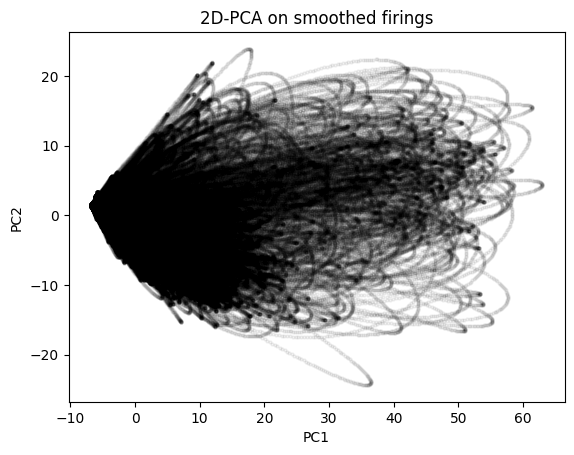

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
PCA_smooth_2d = pca.fit_transform(firings_smooth.T)

plt.figure()
plt.title('2D-PCA on smoothed firings')
plt.scatter(PCA_smooth_2d[:,0], PCA_smooth_2d[:,1], s=5, alpha=.05, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

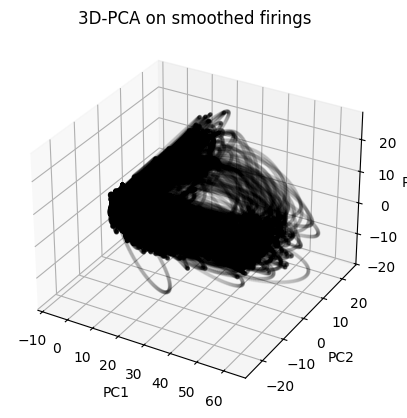

In [20]:
pca = PCA(n_components=3)
PCA_smooth_3d = pca.fit_transform(firings_smooth.T)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-PCA on smoothed firings')
ax.scatter(PCA_smooth_3d[:,0], PCA_smooth_3d[:,1], PCA_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.05)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

#### t-SNE

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_smooth_2d = tsne.fit_transform(firings_smooth.T)

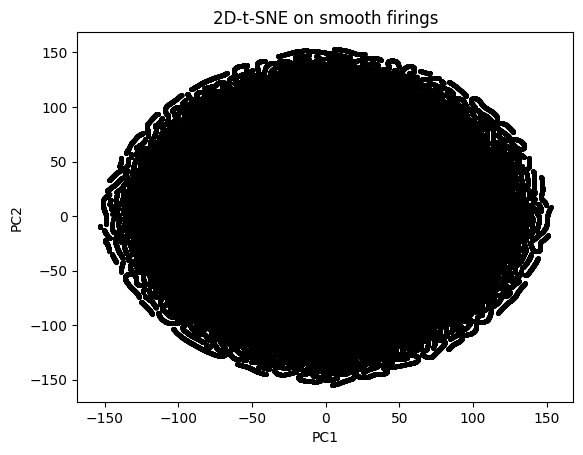

In [22]:
plt.figure()
plt.title('2D-t-SNE on smooth firings')
plt.scatter(tsne_smooth_2d[:,0], tsne_smooth_2d[:,1], s=5, alpha=.5, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-200, 200)
#plt.ylim(-200, 200)
plt.show()

In [23]:
tsne = TSNE(n_components=3)
tsne_smooth_3d = tsne.fit_transform(firings_smooth.T)

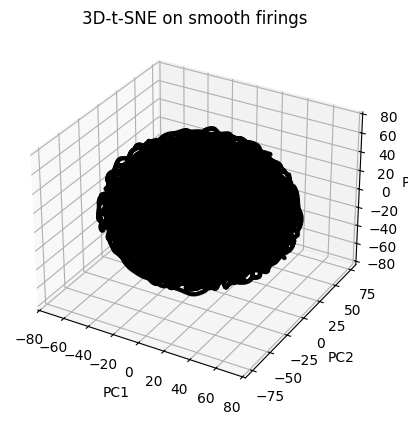

In [24]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-t-SNE on smooth firings')
ax.scatter(tsne_smooth_3d[:,0], tsne_smooth_3d[:,1], tsne_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.05)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#ax.set_xlim(-10, 20)
#ax.set_ylim(-10, 20)
#ax.set_zlim(-20, 20)
plt.show()

#### Umap

In [25]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2)
umap_smooth_2d = umap_model.fit_transform(firings_smooth.T)

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.title('2D-Umap on smooth firings')
plt.scatter(umap_smooth_2d[:,0], umap_smooth_2d[:,1], s=5, alpha=.5, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

In [34]:
umap_model = umap.UMAP(n_components=3)
umap_smooth_3d = umap_model.fit_transform(firings_smooth.T)

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-Umap on smooth firings')
ax.scatter(umap_smooth_3d[:,0], umap_smooth_3d[:,1], umap_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.05)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()